# End-to-end Machine Learning project

Based on the book "Hands-On Machine Learning with Scikit-Learn and TensorFlow" by Aurélien Géron

Adapted from original [notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) by Aurélien Géron 
This notebook requires Python 3.7 or later and scikit-learn 1.0.1 or later.

I highly recommend using [Colab](https://colab.research.google.com/) or a [virtual environment](https://docs.python.org/3/tutorial/venv.html) to keep all your dependencies contained and frozen to a specific version. Note that tensorflow (to be used later in the course) only supports up to Python 3.11 right now, and only supports GPUs on Linux (including WSL2).

In [1]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

## 2. Download the Data

In [2]:
from pathlib import Path
import tarfile
import urllib.request
import pandas as pd

def load_housing_data():
    dir_path = Path("../../datasets")
    tarball_path = dir_path / "housing.tgz"
    if not tarball_path.is_file():
        dir_path.mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path=dir_path)
    return pd.read_csv(dir_path / "housing" / "housing.csv")

housing = load_housing_data()

### Take a Quick Look at the Data Structure
Yes, this is happening before setting aside a test set... but we're not making any decisions yet, just a sanity check.

In [3]:
# look at the first few rows of the housing dataframe
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# summarize the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# look at the categories in the ocean_proximity column
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

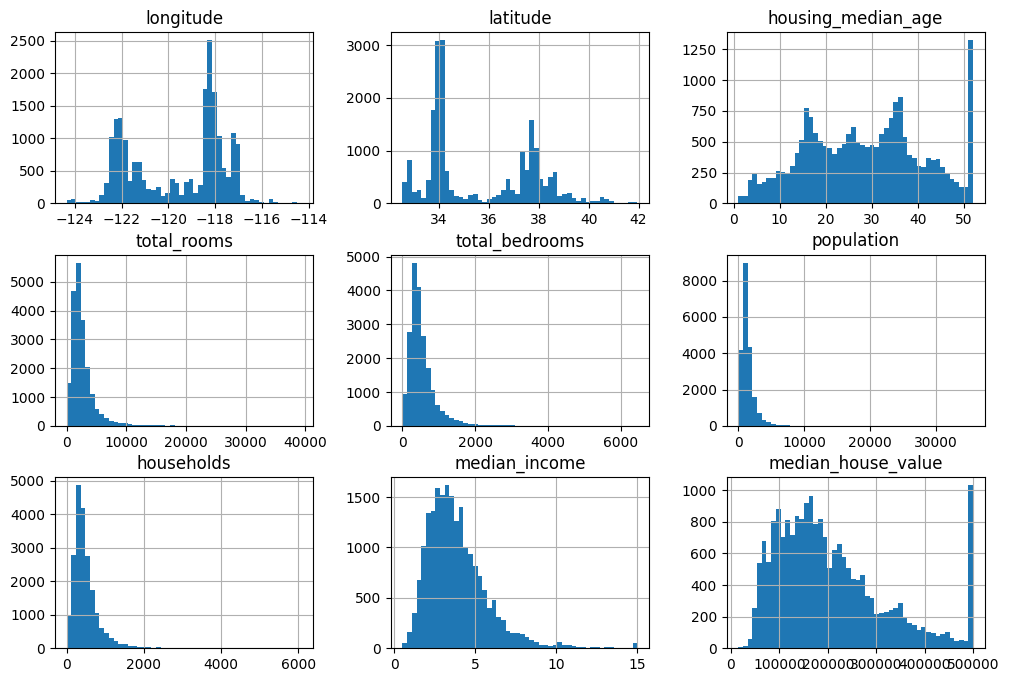

In [6]:

# plot a histogram for each numerical attribute
housing.hist(bins=50, figsize=(12, 8))

### Set aside a test set

In [7]:
# Naive approach: use the index as the identifier and randomly select 20%
import numpy as np
np.random.seed(42)

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print("Training samples: ", len(train_set), "Testing samples: ", len(test_set))

Training samples:  16512 Testing samples:  4128


#### Hash-based identifier
Instead of randomly permuting the indices, we can compute a hash of each instance's identifier and select samples that are less than 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if we refresh the dataset.

In [9]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

Unfortunately this dataset doesn't have a unique identifier other than the row number, which doesn't protect against insertions in the dataset. Another solution is to pick something that uniquely identifies the sample, such as a combination of the district's latitude and longitude (although this isn't perfect either, as some districts may be close enough together that their ids are computed to be the same).

In [11]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [12]:
# scikit-learn's train_test_split function does basically the same thing as shuffle_and_split_data, with some added magic
# This function is commonly used but it's important to understand its assumptions and limitations!
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#### Side tangent: Sampling bias with binary data

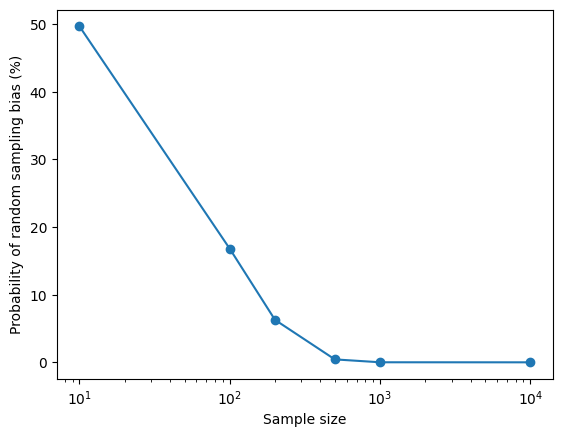

In [13]:
from scipy.stats import binom
import matplotlib.pyplot as plt

p = 0.8 # ratio of likes cilantro to dislikes cilantro
buffer = 0.05 # plus/minus 5%
sample_sizes = [10, 100, 200, 500, 1000, 10000]
prob_bias = []

for n in sample_sizes:
    too_small = n * (p - buffer)
    too_large = n * (p + buffer)
    proba_too_small = binom(n, p).cdf(too_small - 1)
    proba_too_large = 1 - binom(n, p).cdf(too_large)
    prob_bias.append((proba_too_small + proba_too_large) * 100)

plt.plot(sample_sizes, prob_bias, "o-")
plt.xlabel("Sample size")
plt.ylabel("Probability of random sampling bias (%)")
plt.xscale("log")
plt.show()

#### Stratified sampling
Instead of taking a naive random sample, we can use **stratified sampling** to ensure that the test set is representative of the overall population. The population is divided into smaller subgroups called **strata**, and a representative random sample is drawn from each.

Scikit-learn provides a handy option for this in `train_test_split`, but we need to decide what the strata should be. Here's where **domain knowledge** comes in - in this case, let's say we were told that the current manual process uses median income as a proxy for median housing price, so we should make sure that the test set is representative of the income distribution.

Text(0, 0.5, 'Median house value')

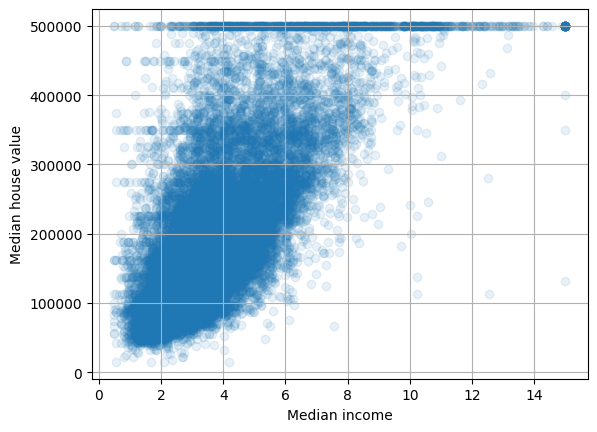

In [14]:
# check to see that it's a reasonable proxy
plt.scatter(housing["median_income"], housing["median_house_value"], alpha=0.1)
plt.grid(True)
plt.xlabel("Median income")
plt.ylabel("Median house value")

There's some kind of odd stuff going on in this plot, like the obvious ceiling at 500k. There's some weaker lines at 450k and 350k as well. Eventually we might want to deal with these outliers, but for now we'll ignore them.

<Axes: >

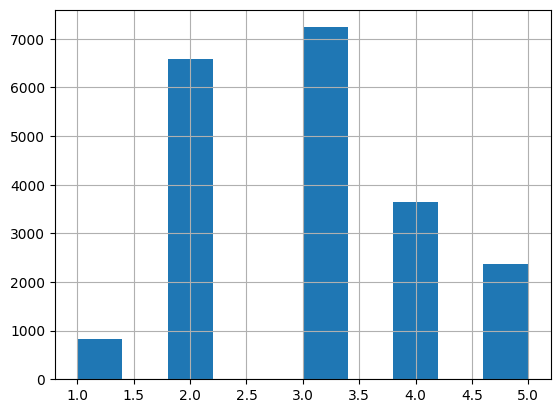

In [15]:
# split the median income into reasonable categories in order to create strata buckets
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [16]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

<Axes: >

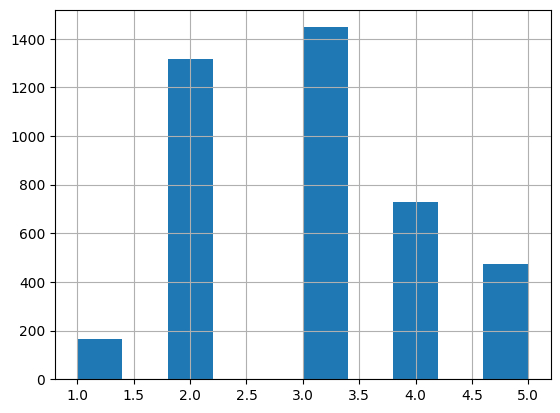

In [17]:
# verify the sampling by looking at the histogram of the test set
strat_test_set["income_cat"].hist()

In [18]:
# We don't actually want the income_cat column sticking around, so let's drop it
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [19]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


## 3. Discover and Visualize the Data to Gain Insights

In [20]:
# Make a copy of the training set to mess around with
housing = strat_train_set.copy()

### Visualizing Geographical Data

Not every data set makes sense to plot on a map, but in this case we have latitude and longitude. Might as well plot it.

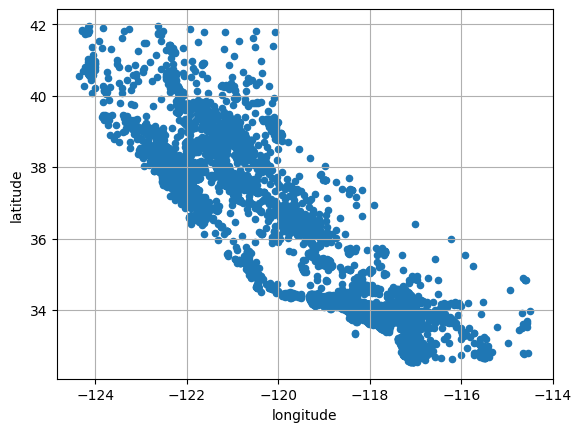

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

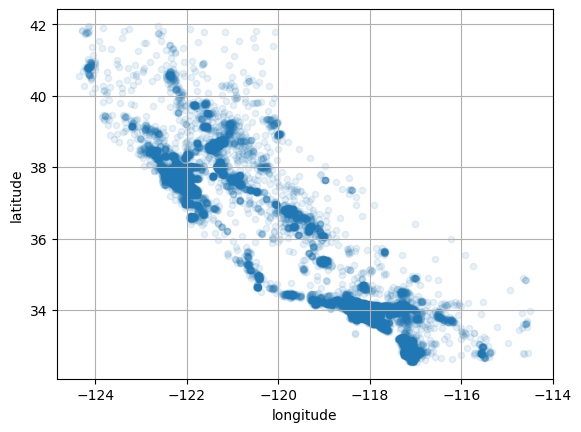

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.1)
plt.show()

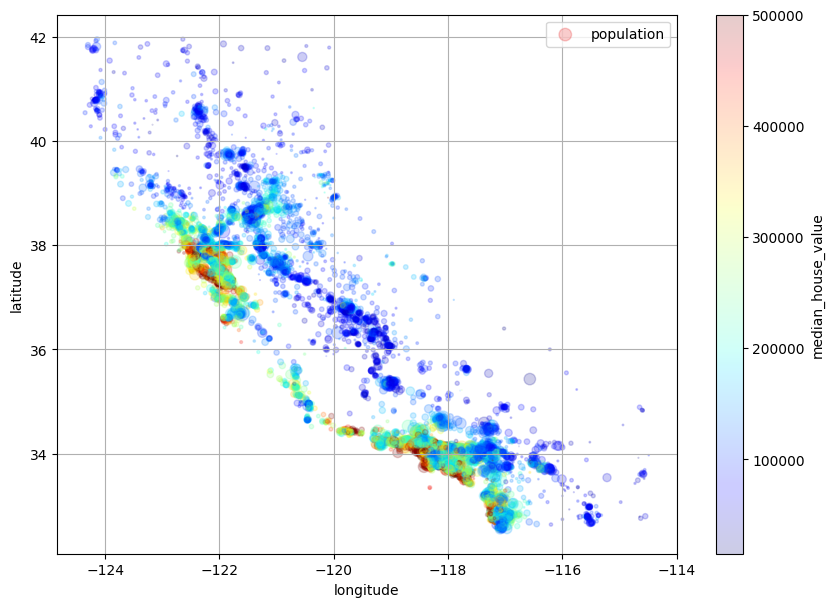

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, figsize=(10, 7), alpha=0.2)
plt.show()

### Looking for Correlations
Before diving in to a machine learning model, we probably want to take a look at which features are most correlated with the target.

In [24]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

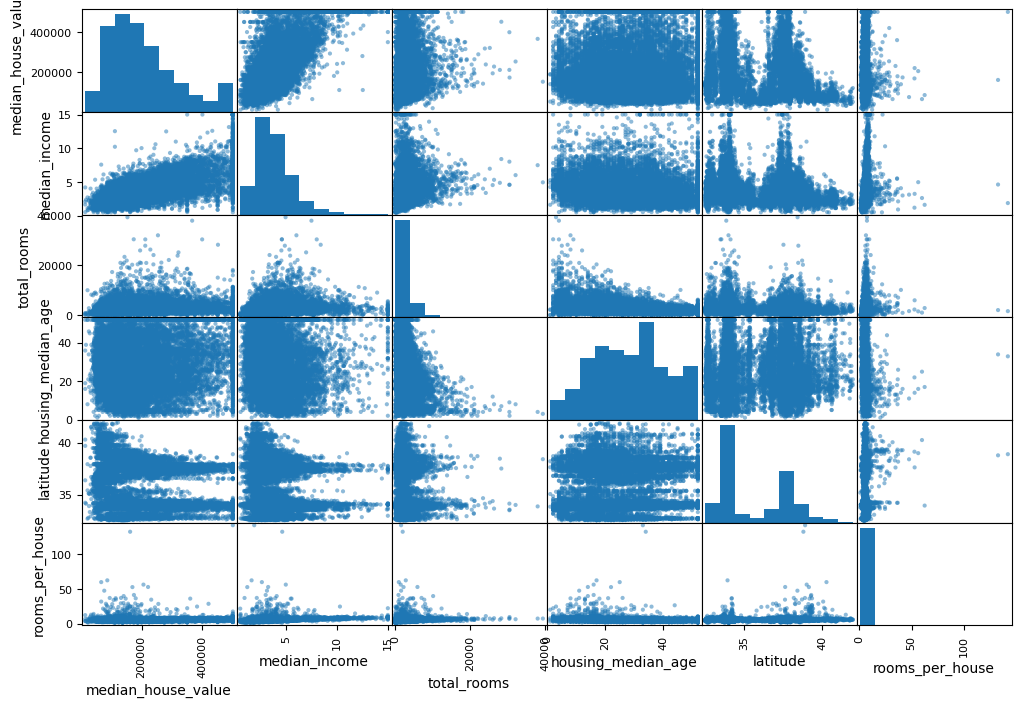

In [25]:
# pandas' scatter_matrix function plots every numerical attribute against every other numerical attribute
# This can be useful, but you probably want to restrict the number of attributes to plot

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age","latitude", "rooms_per_house"]
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

(0.0, 20.0)

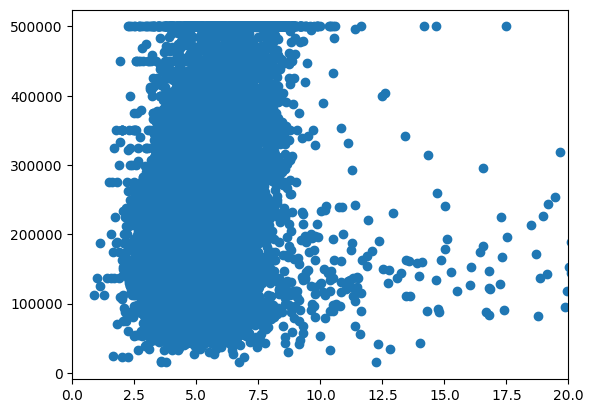

In [26]:
plt.scatter(housing["rooms_per_house"], housing["median_house_value"])
plt.xlim([0,20])

In [27]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256
1286,-121.31,37.96,52.0,1829.0,301.0,694.0,319.0,3.3466,92600.0,INLAND,5.733542
18078,-118.36,33.85,34.0,1086.0,197.0,509.0,158.0,6.1133,349300.0,<1H OCEAN,6.873418
4396,-122.13,37.41,36.0,4787.0,900.0,2039.0,890.0,5.4063,440900.0,NEAR BAY,5.378652
18031,-118.44,34.31,22.0,3182.0,822.0,2661.0,746.0,2.7472,160100.0,<1H OCEAN,4.265416
6753,-118.13,34.06,17.0,1714.0,572.0,1590.0,568.0,1.1875,183900.0,<1H OCEAN,3.017606


## 4. Prepare the Data for Machine Learning Algorithms
### Experimenting with Attribute Combinations

Aka **feature engineering**. This is another place where domain knowledge is important!

In [28]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]
housing["people_per_bedroom"] = housing["population"] / housing["total_bedrooms"]

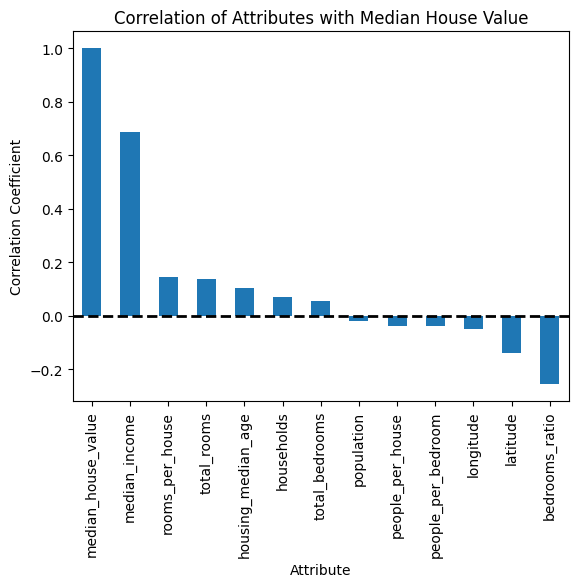

In [29]:
corr_matrix = housing.corr(numeric_only=True)
corr_sorted = corr_matrix["median_house_value"].sort_values(ascending=False)
corr_sorted.plot(kind="bar")
plt.plot([-0.5, len(corr_sorted)], [0, 0], "k--", linewidth=2)
plt.xticks(rotation=90)
plt.xlabel("Attribute")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation of Attributes with Median House Value")
plt.show()

### Data Cleaning
We don't want the target (the median house value) to be in the predictors, so we'll split the training set into predictor and target (often called $X$ and $y$, but we'll stick with `housing` and `housing_labels` for now).

In [30]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Missing features
Most ML algorithms can't deal with missing features, so we need to do so during the wrangling step.

In [31]:
# First, let's look at the missing values in the total_bedrooms column
null_rows_idx = housing.isnull().any(axis=1)
print(f"Missing {len(housing[null_rows_idx])} of {len(housing)} rows")
housing.loc[null_rows_idx].head()

Missing 168 of 16512 rows


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


Replacing the NaN values with the median is surprisingly common, as it preserves the most data. Scikit-learn provides a `SimpleImputer` class to do this automatically. There's also `KNNImputer` which uses the $k$ nearest neighbors to fill in the missing values, or `IterativeImputer` which repeatedly trains a regression model to predict the missing values.

In [32]:
from sklearn.impute import KNNImputer, SimpleImputer

# imputer = SimpleImputer(strategy="median")
imputer = KNNImputer()

It doesn't work on text data, so we need to filter the dataframe to just include numeric types. After that, we can use the imputer as a **transformer** to fill in the missing values.

In [33]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,923.2,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,448.2,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,266.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,700.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,189.2,375.0,183.0,9.8020


In [34]:
from sklearn import set_config

set_config(transform_output="pandas")  # scikit-learn >= 1.2

#### Outliers

As we saw on the various scatter plots, there's some outliers in the data. One way to detect them is to use an [isolation forest](https://doi.org/10.1109/ICDM.2008.17), which recursively splits the data into subsets until each contains only one sample. Outliers are samples that require fewer splits to isolate. The `IsolationForest` class in scikit-learn implements this algorithm and can be used to train a model to predict an anomaly score for each sample, with -1 being an outlier and 1 being an inlier.

In [35]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred[outlier_pred == -1].size / outlier_pred.size

0.12990552325581395

If you wanted to drop outliers, you would run the following code:

In [36]:
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

#### Handling Text and Categorical Attributes

Most of the math in ML algorithms is based on numbers, so we need to convert text and categorical attributes to numbers. This is called **encoding**.

In [37]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x1c8ff9e4320>,
 [Text(0, 0, '<1H OCEAN'),
  Text(1, 0, 'INLAND'),
  Text(2, 0, 'ISLAND'),
  Text(3, 0, 'NEAR BAY'),
  Text(4, 0, 'NEAR OCEAN')])

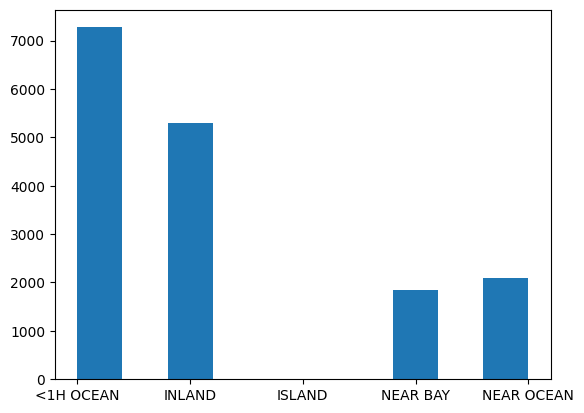

In [38]:
# Option 1: Ordinal encoding
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

plt.hist(housing_cat_encoded)
plt.xticks(range(5), ordinal_encoder.categories_[0])

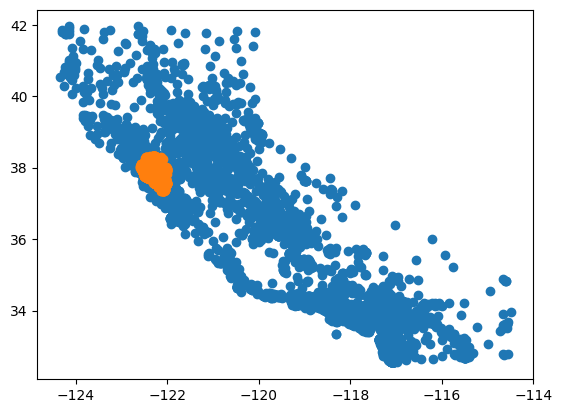

In [39]:
near_bay = housing["ocean_proximity"] == "NEAR BAY"
plt.scatter(housing["longitude"],housing["latitude"])
plt.scatter(housing["longitude"][near_bay],housing["latitude"][near_bay])

An alternative method is a **One-hot encoder**, which creates a new binary attribute for each category. This can get really big if there are a lot of categories, but it's fine for this dataset.

In [40]:
# Option 2: One-hot encoding
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False) # pandas doesn't like sparse matrices
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0


#### Feature Scaling

The last piece of data cleaning that we want to look at is feature scaling. Many ML algorithms don't like hugely different scales, so we want to scale the features to be similar. Two popular methods are **min-max scaling** and **standardization**.

It is essential to understand the data to know what kind of scaling is appropriate.

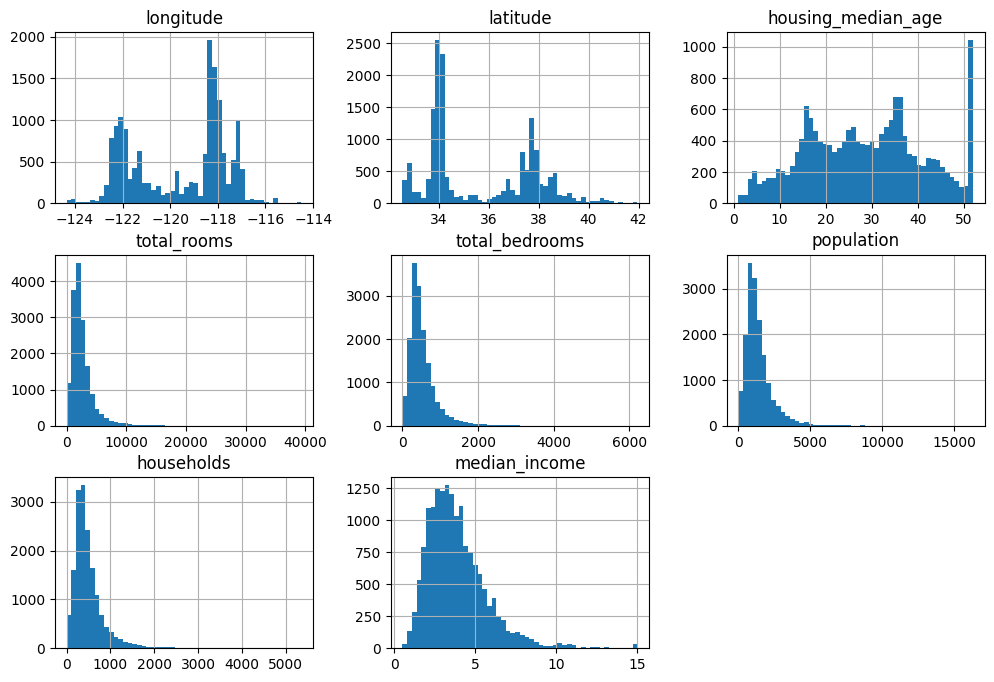

In [41]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

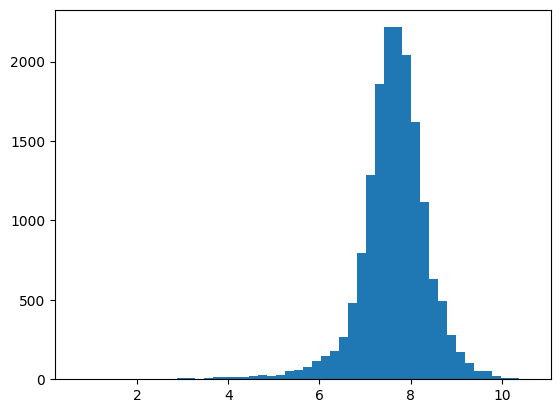

In [45]:
mean = housing.total_rooms.mean()
std = housing.total_rooms.std()

# plt.hist((housing.total_rooms - mean) / std, 50)
plt.hist(np.log(housing.total_rooms), 50)
plt.show()

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>, <Axes: >]],
      dtype=object)

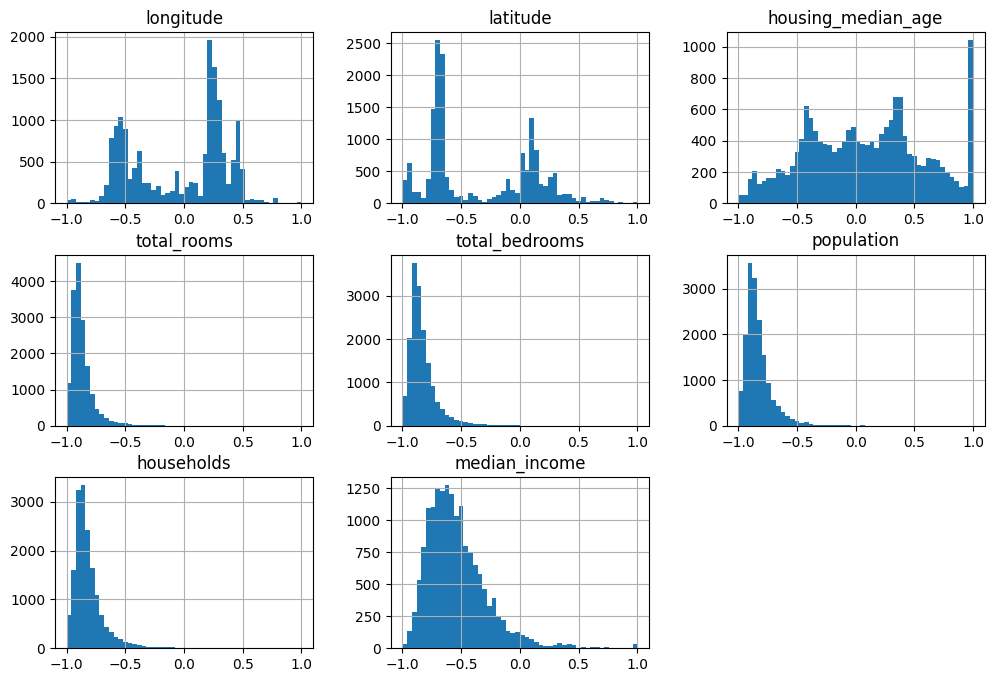

In [43]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
housing_num_min_max_scaled.hist(bins=50, figsize=(12, 8))

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>, <Axes: >]],
      dtype=object)

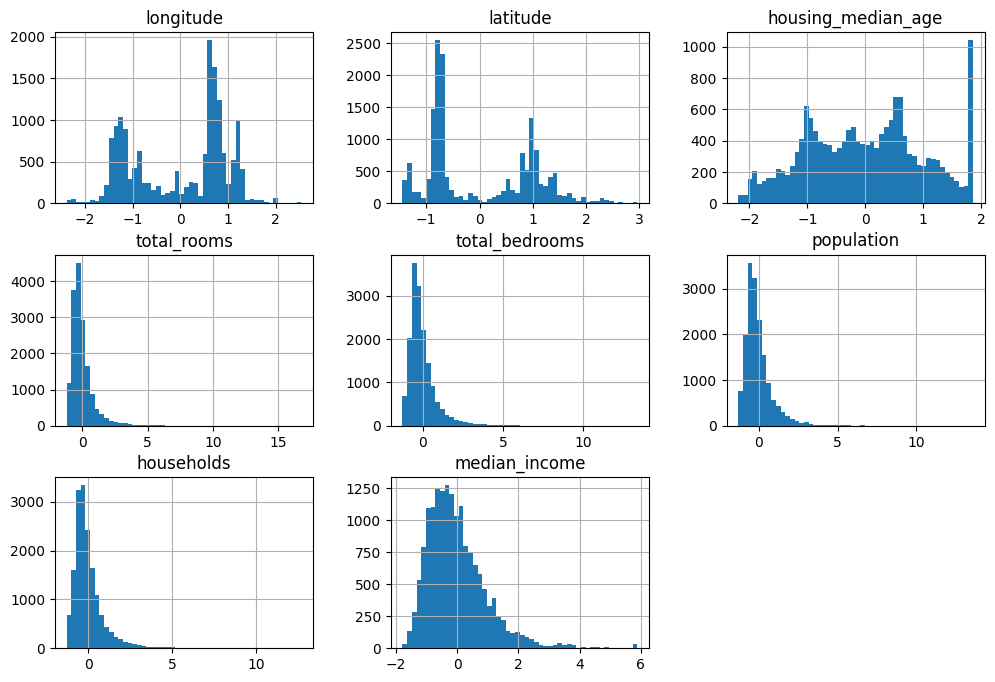

In [44]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
housing_num_std_scaled.hist(bins=50, figsize=(12, 8))

#### Other transformations
Sometimes you might want to do things like log-transform the data to deal with long tails (skewness), or even convert a numerical attribute to a categorical one to deal with a multi-modal distribution (like `latitude` above). The book goes into details on a few more examples, but the main takeaway is that there is no rule that says you need to feed your data as-is into an ML algorithm, and data transformations might make sense.

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

#### Transformation Pipelines

Data transformations are so common that most frameworks have a way of handling them efficiently. We'll set up a pipeline of functional transformations that will be applied to the data in sequence. A key thing to note is that the pipeline is fit to the **training data** - you should never re-normalize based on test data, for example.

In [46]:
from sklearn.pipeline import Pipeline

# let's go with the median imputer to fill in the missing total_bedrooms value
# Use the standard scaler for normalization
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [47]:
# Note: the book and original version of this notebook include some fancier methods of
# composing pipelines. I've removed them as it's all just syntax.
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ocean_proximity'])])

In [48]:
# Fit the transform to the housing data, which is just the training set
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.head()

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0


In [52]:
# Finally we can train some kind of model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

model = DecisionTreeRegressor()
#model = LinearRegression()

pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", model)
])

pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['ocean_proximity'])])),
                ('model', DecisionTreeRegressor())])

In [50]:
# Convenient function to evaluate performance
from sklearn.metrics import mean_absolute_error
def plot_predictions(actual, pred):
    plt.scatter(actual, pred, alpha=0.1)
    plt.plot([0, 500000], [0, 500000], color="red")
    plt.xlabel("Actual Median House Value ($)")
    plt.ylabel("Predicted Median House Value ($)")
    mae = mean_absolute_error(actual, pred)
    plt.text(300000, 10000, f"MAE = ${mae:.2f}")

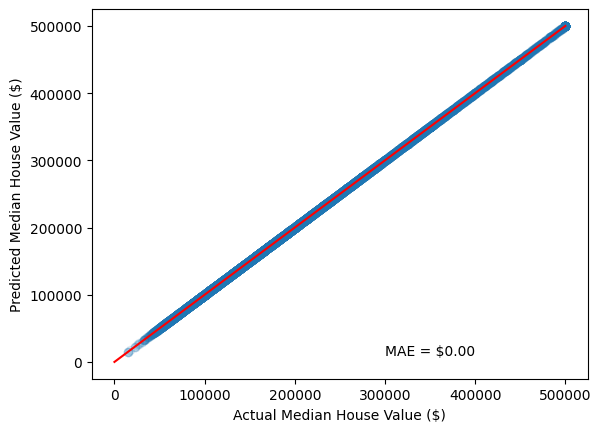

In [53]:
y_est = pipeline.predict(housing)
plot_predictions(housing_labels, y_est)

In [54]:
from sklearn.model_selection import cross_val_predict
cv_predictions = cross_val_predict(pipeline, housing, housing_labels, cv=10)

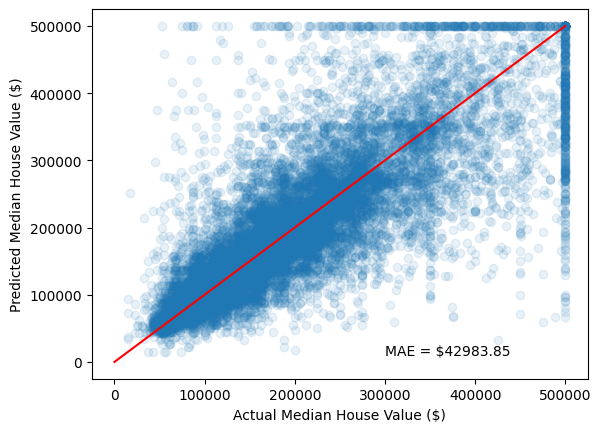

In [55]:
plot_predictions(housing_labels, cv_predictions)

In [56]:
import joblib
joblib.dump(pipeline, "housing_model.pkl", compress=1)

['housing_model.pkl']